In [ ]:
!pip install colorama

In [ ]:
import copy
import random
import matplotlib.pyplot as plt
import numpy as np


class GameBoard:
    def __init__(self, gamestr_h, gamestr_v):
        self.gamestr_h = gamestr_h
        self.gamestr_v = gamestr_v
        self.board = {}
        self.nb_rows = 0
        self.nb_cols = 0
        self.domain = {}

    def parse_horizontal(self):
        i, j, segh = 0, 0, 0
        for c in self.gamestr_h:
            if c == 'x':
                self.board[(i, j, segh, 0)] = -1
                j += 1
            elif c == 'r':
                i += 1
                j = 0
                segh = 0
            elif c in 'wb':
                segh += 1
                j += 1 if c == 'b' else 0
            else:
                self.board[(i, j, segh, 0)] = int(c)
                j += 1
        self.nb_rows = i + 1

    def parse_vertical(self):
        i, j, segv = 0, 0, 0
        for c in self.gamestr_v:
            if c == 'x':
                self.board[(i, j, 0, segv)] = -1
                i += 1
            elif c == 'c':
                j += 1
                i = 0
                segv = 0
            elif c in 'wb':
                segv += 1
                i += 1 if c == 'b' else 0
            else:
                self.board[(i, j, 0, segv)] = int(c)
                i += 1
        self.nb_cols = j + 1

    def merge_segments(self):
        for i in range(self.nb_rows):
            for j in range(self.nb_cols):
                groupby = [k for k in self.board.keys() if k[0] == i and k[1] == j]
                if not groupby:
                    continue
                max_segh = max(k[2] for k in groupby)
                max_segv = max(k[3] for k in groupby)
                value = self.board[groupby[0]]
                for k in groupby:
                    del self.board[k]
                self.board[(i, j, max_segh, max_segv)] = value

    def segment_analysis(self):
        self._segment_rows()
        self._segment_cols()

    def _segment_rows(self):
        self.row_segh = {}
        for r in range(self.nb_rows):
            counter, segh = 0, 0
            for key in self.board.keys():
                if key[0] == r:
                    if key[2] != segh:
                        self.row_segh[(r, segh)] = counter
                        segh += 1
                        counter = 0
                    counter += 1
            self.row_segh[(r, segh)] = counter

    def _segment_cols(self):
        self.col_segv = {}
        for c in range(self.nb_cols):
            counter, segv = 0, 0
            for key in self.board.keys():
                if key[1] == c:
                    if key[3] != segv:
                        self.col_segv[(c, segv)] = counter
                        segv += 1
                        counter = 0
                    counter += 1
            self.col_segv[(c, segv)] = counter

    def compute_domains(self):
        for k in self.board.keys():
            if self.board[k] != -1:
                self.domain[k] = {self.board[k]}
            else:
                row_limit = self.row_segh[(k[0], k[2])]
                col_limit = self.col_segv[(k[1], k[3])]
                self.domain[k] = set(range(1, min(row_limit, col_limit) + 1))

    @staticmethod
    def forward_propagate(domain):
        operations = 0
        for k in domain.keys():
            if len(domain[k]) == 1:
                neighbors = [k1 for k1 in domain.keys() if k != k1 and (
                        (k[0] == k1[0] and k[2] == k1[2]) or (k[1] == k1[1] and k[3] == k1[3]))]
                for neighbor in neighbors:
                    if domain[k].issubset(domain[neighbor]):
                        domain[neighbor] -= domain[k]
                        operations += 1
        return operations

    @staticmethod
    def backtrack(domain):
        if all(len(values) == 1 for values in domain.values()):
            return True, domain

        variable = random.choice([k for k in domain.keys() if len(domain[k]) > 1])
        for value in domain[variable]:
            new_domain = copy.deepcopy(domain)
            new_domain[variable] = {value}
            GameBoard.forward_propagate(new_domain)

            if any(len(values) == 0 for values in new_domain.values()):
                continue

            solved, solution = GameBoard.backtrack(new_domain)
            if solved:
                return solved, solution

        return False, {}

    def solve(self):
        operations = 1
        while operations != 0:
            operations = self.forward_propagate(self.domain)
        _, solution = self.backtrack(copy.deepcopy(self.domain))
        return solution

    def draw_colored_grid_with_wall(self, n, solution):

        grid_values = np.random.randint(1, 9, size=(n, n))

        for k,v in solution.items():
          grid_values[k[0]][k[1]] = list(v)[0]

        # Generate random colors for each box
        colors = np.random.rand(n, n, 3)

        walls, blocks = [], []
        r, c = 0, 0

        for row in gamestr_h.split('r'):
          c = 0
          for col in row:
            if col=="w":
              walls.append((r, c, "left"))
            elif col == "b":
              blocks.append((r, c))
            else:
              c += 1
          r += 1

        r, c = 0, 0

        for col in gamestr_v.split('c'):
          r = 0
          for row in col:
            if row=="w":
              walls.append((r, c, "top"))
            else:
              r += 1
          c += 1

        given_values = []
        for k,v in self.board.items():
          if v != -1:
            given_values.append((k[0], k[1]))




        #Create the figure
        fig, ax = plt.subplots(figsize=(n, n))

        # Draw the entire n x n grid with random colors and numbers
        for i in range(n):
            for j in range(n):
                # Draw each grid cell with random color
                ax.add_patch(plt.Rectangle((j, n - i - 1), 1, 1, color="white"))
                # Add the numerical value to each cell
                ax.text(j + 0.5, n - i - 1 + 0.5, str(grid_values[i, j]),
                        color="red", ha='center', va='center', fontsize=12, weight='bold')

        for i,j in given_values:
          ax.text(j + 0.5, n - i - 1 + 0.5, str(grid_values[i, j]),
                        color="blue", ha='center', va='center', fontsize=12, weight='bold')

        for block in blocks:
          i,j = block
          ax.add_patch(plt.Rectangle((j, n - i - 1), 1, 1, color="black"))
          ax.text(j + 0.5, n - i - 1 + 0.5, str(grid_values[i, j]),
                  color="black", ha='center', va='center', fontsize=12, weight='bold')


        # Highlight only one wall (left or right) of the specified cell
        for wall in walls:
          r, c, side = wall
          if side == 'left':
            ax.add_patch(plt.Rectangle((c, n - r - 1), 0.1, 1, color='black'))  # Left wall change
          if side == 'top':
            ax.add_patch(plt.Rectangle((c, n - r - 0.1), 1, 0.1, color='black'))  # top wall change

        # Set grid and visualization properties
        ax.set_xlim(0, n)
        ax.set_ylim(0, n)
        ax.set_xticks(np.arange(0, n + 1, 1))
        ax.set_yticks(np.arange(0, n + 1, 1))
        ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        # plt.show()

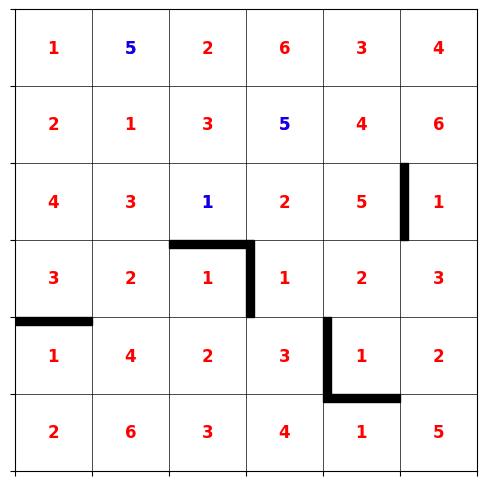

In [ ]:
gamestr_h = "x5xxxxrxxx5xxrxx1xxwxrxxxwxxxrxxxxwxxrxxxxxx"
gamestr_v = "xxxxwxxc5xxxxxcxx1wxxxcx5xxxxcxxxxxwxcxxxxxx"

game = GameBoard(gamestr_h, gamestr_v)
game.parse_horizontal()
game.parse_vertical()
game.merge_segments()
game.segment_analysis()
game.compute_domains()

solution = game.solve()
game.draw_colored_grid_with_wall(round(len(solution)**(1/2)), solution)

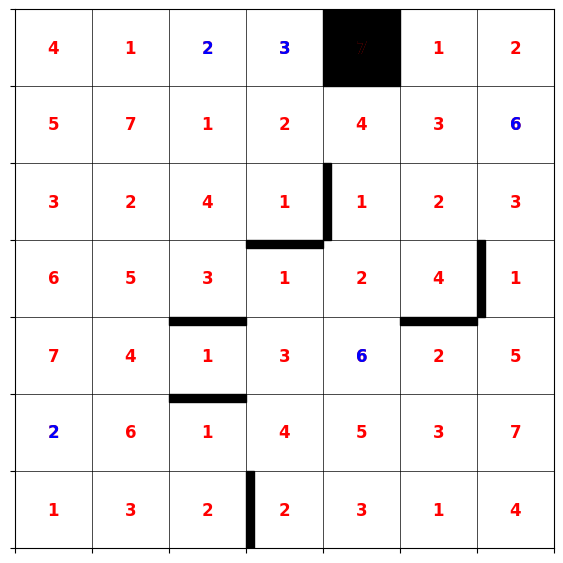

In [ ]:
gamestr_h = "xx23bxxrxxxxxx6rxxxxwxxxrxxxxxxwxrxxxx6xxr2xxxxxxrxxxwxxxx"
gamestr_v = "xxxxx2xcxxxxxxxc2xxxwxwxxc3xxwxxxxcbxxx6xxcxxxxwxxxcx6xxxxx"

game = GameBoard(gamestr_h, gamestr_v)
game.parse_horizontal()
game.parse_vertical()
game.merge_segments()
game.segment_analysis()
game.compute_domains()

solution = game.solve()
game.draw_colored_grid_with_wall(round(len(solution)**(1/2)), solution)

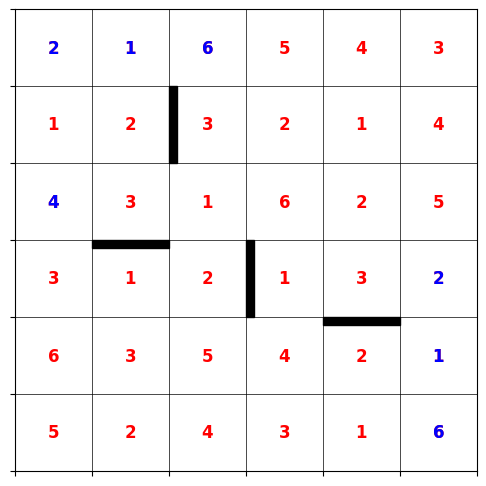

In [ ]:
gamestr_h = "216xxxrxxwxxxxr4xxxxxrxxxwxx2rxxxxx1rxxxxx6"
gamestr_v = "2x4xxxc1xxwxxxc6xxxxxcxxxxxxcxxxxwxxcxxx216"

game = GameBoard(gamestr_h, gamestr_v)
game.parse_horizontal()
game.parse_vertical()
game.merge_segments()
game.segment_analysis()
game.compute_domains()

solution = game.solve()
game.draw_colored_grid_with_wall(round(len(solution)**(1/2)), solution)

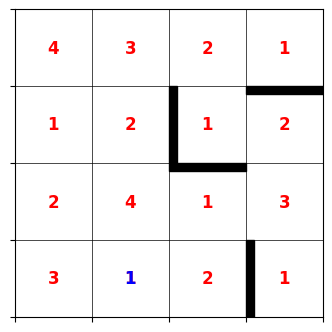

In [ ]:
gamestr_h = "xxxxrxxwxxrxxxxrx1xwx"
gamestr_v = "xxxxcxxx1cxxwxxcxwxxx"

game = GameBoard(gamestr_h, gamestr_v)
game.parse_horizontal()
game.parse_vertical()
game.merge_segments()
game.segment_analysis()
game.compute_domains()

solution = game.solve()
game.draw_colored_grid_with_wall(round(len(solution)**(1/2)), solution)

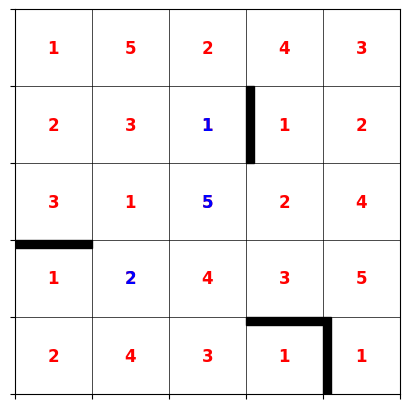

In [ ]:
gamestr_h = "xxxxxrxx1wxxrxx5xxrx2xxxrxxxxwx"
gamestr_v = "xxxwxxcxxx2xcx15xxcxxxxwxcxxxxx"

game = GameBoard(gamestr_h, gamestr_v)
game.parse_horizontal()
game.parse_vertical()
game.merge_segments()
game.segment_analysis()
game.compute_domains()

solution = game.solve()
game.draw_colored_grid_with_wall(round(len(solution)**(1/2)), solution)